# Example to calculate photon-ALP oscillations from NGC 1275

This notebook demonstrates how to calculate the photon-ALP transition probability for NGC 1275, the central AGN of the Perseus cluster. The assumed B-field environments are the same as in Ajello et al. (2016), http://inspirehep.net/record/1432667, and include the cluster field and the magnetic field of the Milky Way. 

In [1]:
from gammaALPs import Source, ALP, ModuleList
from gammaALPs.base import environs, transfer
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patheffects import withStroke
from ebltable.tau_from_model import OptDepth
from astropy import constants as c
from myplot.funcs import *

In [2]:
%matplotlib inline

### Set the ALP

Initialize an ALP object, that stores the ALP mass $m$ (in neV) and the coupling $g$ (in $10^{-11}\mathrm{GeV}^{-1}$).

In [3]:
m, g = 1.,1.
alp = ALP(m,g)

## Set the source

Set the source properties (redshift and sky coordinates) in the ```Source``` containier

In [4]:
ngc1275 = Source(z = 0.017559, ra = '03h19m48.1s', dec = '+41d30m42s')
print (ngc1275.z)
print (ngc1275.ra, ngc1275.dec)
print (ngc1275.l, ngc1275.b)

0.017559
49.950416666666655 41.51166666666666
150.57567432060083 -13.261343544296357


### Init the module list

Initialize the list of transfer modules that will store the different magnetic field environments. 

Energies are supplied in GeV as ```numpy.ndarray```

In [5]:
EGeV = np.logspace(1.,3.5,250)

Now initialize the initial photon polarization. Since we are dealing with a gamma-ray source, no ALPs are initially present in the beam (third diagonal element is zero). The polarization density matrix is normalized such that its trace is equal to one, $\mathrm{Tr}(\rho_\mathrm{in}) = 1$.

In [6]:
pin = np.diag((1.,1.,0.)) * 0.5

In [7]:
m = ModuleList(alp, ngc1275, pin = pin, EGeV = EGeV)

### Add modules:

Now we add propagation modules for the cluster, the EBL, and the Galactic magnetic field.

In [8]:
m.add_propagation("ICMGaussTurb", 
                  0, # position of module counted from the source. 
                  nsim = 10, # number of random B-field realizations
                  B0 = 10.,  # rms of B field
                  n0 = 39.,  # normalization of electron density
                  n2 = 4.05, # second normalization of electron density, see Churazov et al. 2003, Eq. 4
                  r_abell = 500., # extension of the cluster
                  r_core = 80.,   # electron density parameter, see Churazov et al. 2003, Eq. 4
                  r_core2 = 280., # electron density parameter, see Churazov et al. 2003, Eq. 4
                  beta = 1.2,  # electron density parameter, see Churazov et al. 2003, Eq. 4
                  beta2= 0.58, # electron density parameter, see Churazov et al. 2003, Eq. 4
                  eta = 0.5, # scaling of B-field with electron denstiy
                  kL = 0.18, # maximum turbulence scale in kpc^-1, taken from A2199 cool-core cluster, see Vacca et al. 2012 
                  kH = 9.,  # minimum turbulence scale, taken from A2199 cool-core cluster, see Vacca et al. 2012
                  q = -2.80, # turbulence spectral index, taken from A2199 cool-core cluster, see Vacca et al. 2012
                  seed=None # random seed for reproducability, set to None for random seed.
                 )
m.add_propagation("EBL",1, model = 'dominguez') # EBL attenuation comes second, after beam has left cluster
m.add_propagation("GMF",2, model = 'jansson12', model_sum = 'ASS') # finally, the beam enters the Milky Way Field

List the module names:

In [9]:
print(m.modules.keys())

['ICMGaussTurb', 'OptDepth', 'GMF']


We can also change the ALP parameters before running the modules:

In [10]:
m.alp.m = 30.
m.alp.g = 0.5

### Run all modules

Now we run the modules. If ```multiprocess``` key word is larger than two, this will be split onto multiple cores with python's ```multiprocess``` module.

The ```px,py,pa``` variables contain the mixing probability into the two photon polarization states (x,y) and into the axion state (a).

In [11]:
px,py,pa = m.run(multiprocess=2)

## Plot the output 

(10, 250)
0.5208456700566624
0.664665602593724


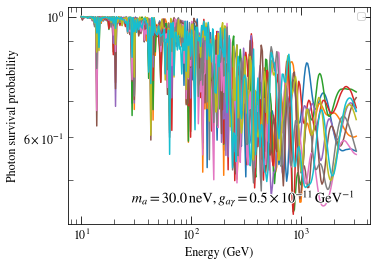

In [12]:
pgg = px + py # the total photon survival probability

print (pgg.shape)
print (np.min(np.median(pgg, axis = 0)))
print (np.min(np.max(pgg, axis = 0)))
effect = dict(path_effects=[withStroke(foreground="w", linewidth=2)])

for p in pgg: # plot all realizations
    plt.semilogx(m.EGeV, p)

plt.xlabel('Energy (GeV)')
plt.ylabel('Photon survival probability')
plt.legend(loc = 0, fontsize = 'medium')

plt.annotate(r'$m_a = {0:.1f}\,\mathrm{{neV}}, g_{{a\gamma}} = {1:.1f} \times 10^{{-11}}\,\mathrm{{GeV}}^{{-1}}$'.format(m.alp.m,m.alp.g),
             xy = (0.95,0.1), size = 'x-large', xycoords = 'axes fraction', ha = 'right',**effect)

plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.subplots_adjust(left = 0.2)
plt.savefig("pgg.png", dpi = 150)

# Save results

Save the results in an astropy table. 

In [13]:
from astropy.table import Table

In [14]:
c = {}
c['pgg'] = np.vstack((EGeV, pgg))
t = Table(c)

In [15]:
t.write('ngc1275.fits', overwrite = True)

In [16]:
t1 = Table.read('ngc1275.fits')

In [17]:
t1

pgg [250]
float64
10.0 .. 3162.2776601683795
0.9997759984981482 .. 0.5646777728565108
0.9996567607907973 .. 0.6017798766952647
0.9997328444174709 .. 0.7262736590433336
0.9998309892226025 .. 0.6791372494659588
0.9998980760776965 .. 0.6686536682035805
0.9995486061528456 .. 0.7088063682898635
0.9993419654299501 .. 0.5569992604766765
0.9996585998388444 .. 0.5657850944138351


### Plot the magnetic field of the cluster, stored in module 0

Text(0.5, 0, '$r$ (kpc)')

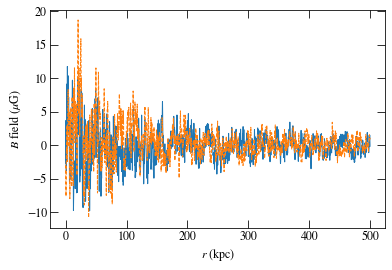

In [18]:
plt.plot(m.modules["ICMGaussTurb"].r,m.modules["ICMGaussTurb"].B * np.sin(m.modules["ICMGaussTurb"].psi),
         lw=1)
plt.plot(m.modules["ICMGaussTurb"].r,m.modules["ICMGaussTurb"].B * np.cos(m.modules["ICMGaussTurb"].psi),
         lw=1, ls = '--') 
plt.ylabel('$B$ field ($\mu$G)')
plt.xlabel('$r$ (kpc)')

And plot the electron density:

Text(0.5, 0, '$r$ (kpc)')

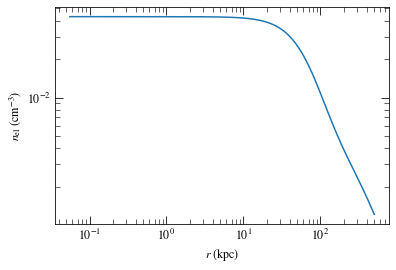

In [19]:
plt.loglog(m.modules["ICMGaussTurb"].r,m.modules[0].nel * 1e-3)
plt.ylabel('$n_\mathrm{el}$ (cm$^{-3}$)')
plt.xlabel('$r$ (kpc)')

#### Calculate the rotation measure of the field

In [20]:
m.modules["ICMGaussTurb"].Bfield_model.seed = None
rm = m.modules[0]._b.rotation_measure(m.modules["ICMGaussTurb"].r,
                                      n_el=m.modules["ICMGaussTurb"].nel * 1e-3,
                                      nsim=1000)

Taylor et al. (2006) found RM values between 6500 and 7500 rad m^-2. Comparing B-field realizations to that number:

RM mean +/- sqrt(var) in rad m^-2: 19.52 +/- 3256.81
2.100% of B field realizations have |RM| > 7500 rad m^-2


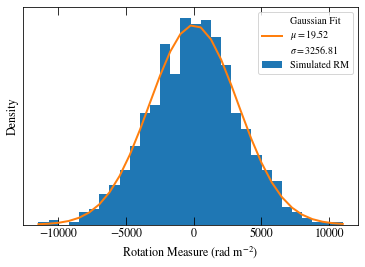

In [21]:
from scipy.stats import norm

n, bins, _ =  plt.hist(np.sort((rm)), bins=30, density=True, label="Simulated RM")

plt.xlabel("Rotation Measure (rad m${}^{-2}$)")
plt.ylabel("Density")

mean = np.mean(rm)
var = np.var(rm)
print ("RM mean +/- sqrt(var) in rad m^-2: {0:.2f} +/- {1:.2f}".format(mean, np.sqrt(var)))

plt.plot(bins, norm.pdf(bins, loc=mean, scale=np.sqrt(var)),
         lw=2,
         label="Gaussian Fit\n$\mu = {0:.2f}$\n$\sigma={1:.2f}$".format(mean, np.sqrt(var)))

print ("{0:.3f}% of B field realizations have |RM| > 7500 rad m^-2".format((np.abs(rm) > 7500).sum() / rm.size * 100.))

plt.legend()

plt.gca().tick_params(labelleft=False,  left=False, right=False)
plt.savefig("sim_rm_perseus.png", dpi=150)

### Plot the magnetic field of the Milky Way

Text(0.5, 0, '$r$ (kpc)')

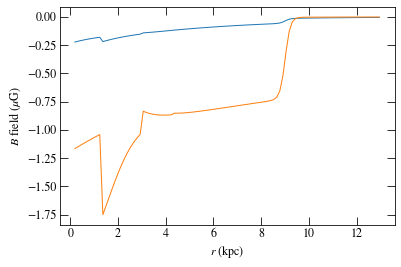

In [22]:
plt.plot(m.modules["GMF"].r, m.modules["GMF"].B * np.sin(m.modules["GMF"].psi),
         lw = 1)
plt.plot(m.modules["GMF"].r, m.modules["GMF"].B * np.cos(m.modules["GMF"].psi),
         lw = 1) 
plt.ylabel('$B$ field ($\mu$G)')
plt.xlabel('$r$ (kpc)')